# KAN-based Autoregressive Model for Stock Forecasting

This notebook demonstrates how to use Kolmogorov-Arnold Networks (KANs) for stock price prediction using an autoregressive approach.

## Why KAN for Stock Prediction?

KANs offer several advantages over traditional MLPs for time series:
1. **Learnable activation functions**: KAN uses B-splines on edges, allowing the model to learn complex non-linear relationships
2. **Better interpretability**: The learned functions can be visualized and understood
3. **Handling non-smooth functions**: Stock data often has regime changes and discontinuities
4. **Parameter efficiency**: KANs can achieve similar or better performance with fewer parameters

## Approach

We'll implement an autoregressive model where:
- Input: Past N days of returns (or prices)
- Output: Next day's return (or price)
- Model: KAN network that learns the non-linear relationships

In [4]:
# Install required packages
!pip install tqdm

You should consider upgrading via the '/Users/method314/kan-stock-forecasting/venv/bin/python3 -m pip install --upgrade pip' command.


In [5]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

from kan import KAN, create_dataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

Libraries imported successfully!
PyTorch version: 2.8.0
Device: cpu


## 1. Fetch Stock Data from EODHD

EODHD (End of Day Historical Data) provides financial data APIs.
You'll need an API key from: https://eodhistoricaldata.com/

In [8]:
# Configuration
EODHD_API_KEY = "670ceb23789f77.90838622"  # Replace with your EODHD API key
TICKER = "MSFT.US"  # Stock ticker (format: SYMBOL.EXCHANGE)
START_DATE = "2020-01-01"
END_DATE = datetime.now().strftime("%Y-%m-%d")

def fetch_stock_data(ticker, start_date, end_date, api_key):
    """
    Fetch stock data from EODHD API
    
    Args:
        ticker: Stock symbol with exchange (e.g., 'AAPL.US')
        start_date: Start date in 'YYYY-MM-DD' format
        end_date: End date in 'YYYY-MM-DD' format
        api_key: EODHD API key
    
    Returns:
        pandas DataFrame with stock data
    """
    url = f"https://eodhistoricaldata.com/api/eod/{ticker}"
    params = {
        'api_token': api_key,
        'from': start_date,
        'to': end_date,
        'fmt': 'json'
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        if not data:
            raise ValueError("No data returned from API")
        
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date').reset_index(drop=True)
        
        return df
    
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        print("\nFalling back to synthetic data for demonstration...")
        return generate_synthetic_data(start_date, end_date)

def generate_synthetic_data(start_date, end_date):
    """
    Generate synthetic stock data for testing without API key
    """
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    n = len(dates)
    
    # Generate synthetic price with trend and volatility
    np.random.seed(42)
    trend = np.linspace(100, 150, n)
    seasonal = 10 * np.sin(np.linspace(0, 8*np.pi, n))
    noise = np.random.randn(n).cumsum() * 2
    close = trend + seasonal + noise
    
    # Generate OHLV data based on close
    high = close + np.abs(np.random.randn(n)) * 2
    low = close - np.abs(np.random.randn(n)) * 2
    open_price = close + np.random.randn(n) * 1.5
    volume = np.random.randint(1000000, 10000000, n)
    
    df = pd.DataFrame({
        'date': dates,
        'open': open_price,
        'high': high,
        'low': low,
        'close': close,
        'volume': volume
    })
    
    return df

# Fetch data
print(f"Fetching data for {TICKER} from {START_DATE} to {END_DATE}...")
stock_data = fetch_stock_data(TICKER, START_DATE, END_DATE, EODHD_API_KEY)

print(f"\nData shape: {stock_data.shape}")
print(f"Date range: {stock_data['date'].min()} to {stock_data['date'].max()}")
print("\nFirst few rows:")
stock_data.head()

Fetching data for MSFT.US from 2020-01-01 to 2025-10-27...

Data shape: (1462, 7)
Date range: 2020-01-02 00:00:00 to 2025-10-24 00:00:00

First few rows:


,date,open,high,low,close,adjusted_close,volume
0,2020-01-02,158.78,160.73,158.33,160.62,152.7911,22622100
1,2020-01-03,158.32,159.95,158.06,158.62,150.8886,21116200
2,2020-01-06,157.08,159.10,156.51,159.03,151.2786,20813700
3,2020-01-07,159.32,159.67,157.32,157.58,149.8993,21634100
4,2020-01-08,158.93,160.80,157.95,160.09,152.2870,27746500


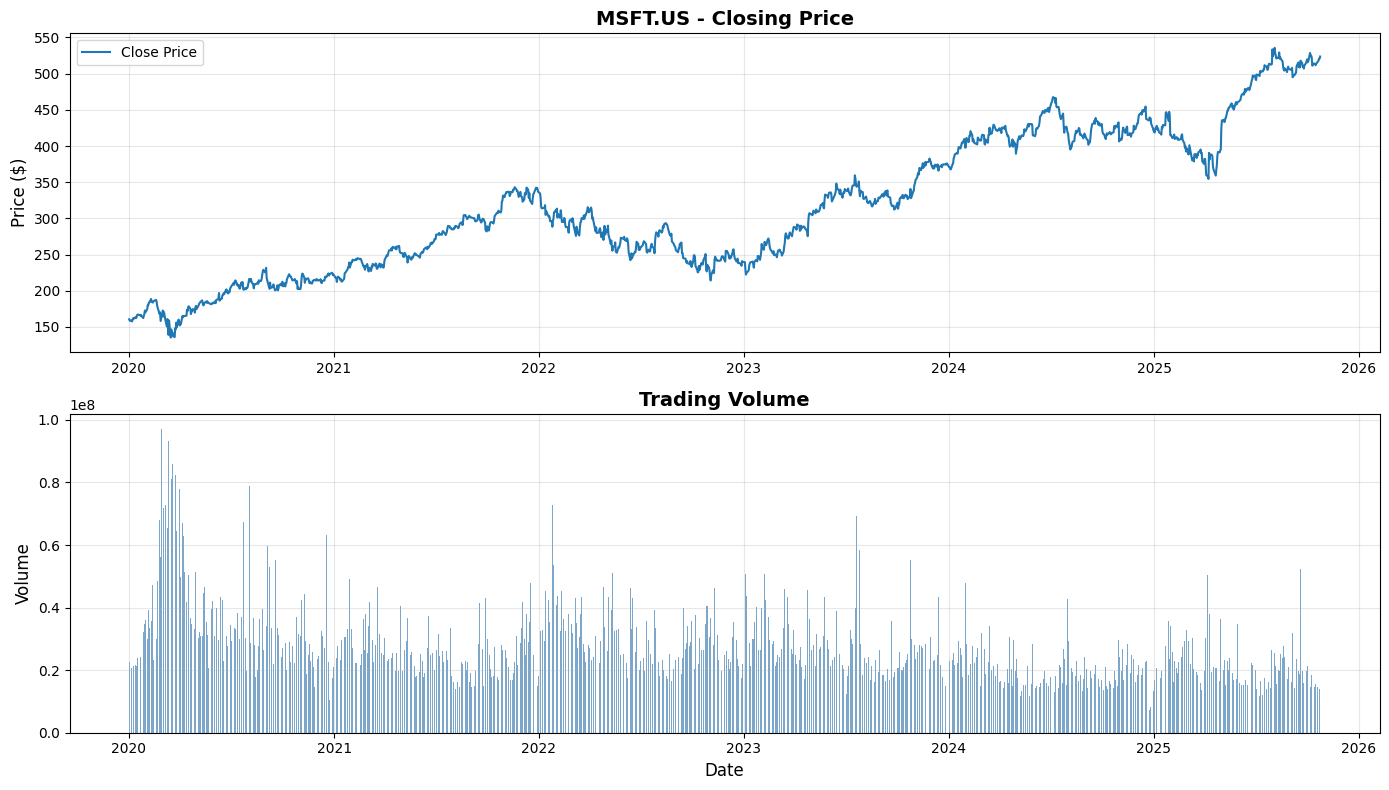

In [9]:
# Visualize the raw data
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Price plot
axes[0].plot(stock_data['date'], stock_data['close'], label='Close Price', linewidth=1.5)
axes[0].set_title(f'{TICKER} - Closing Price', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Volume plot
axes[1].bar(stock_data['date'], stock_data['volume'], alpha=0.7, color='steelblue')
axes[1].set_title('Trading Volume', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Volume', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Feature Engineering for Autoregressive Model

We'll create features based on:
- Past returns (log returns)
- Moving averages
- Volatility measures
- Technical indicators

In [10]:
def create_features(df, lookback_window=10):
    """
    Create autoregressive features for stock prediction
    
    Args:
        df: DataFrame with stock data
        lookback_window: Number of past days to use as features
    
    Returns:
        DataFrame with features
    """
    df = df.copy()
    
    # Calculate returns
    df['returns'] = np.log(df['close'] / df['close'].shift(1))
    
    # Lagged returns (main AR features)
    for i in range(1, lookback_window + 1):
        df[f'return_lag_{i}'] = df['returns'].shift(i)
    
    # Moving averages of returns
    df['ma_5'] = df['returns'].rolling(window=5).mean()
    df['ma_10'] = df['returns'].rolling(window=10).mean()
    
    # Volatility (rolling standard deviation)
    df['volatility_5'] = df['returns'].rolling(window=5).std()
    df['volatility_10'] = df['returns'].rolling(window=10).std()
    
    # Price momentum
    df['momentum_3'] = df['close'] / df['close'].shift(3) - 1
    df['momentum_5'] = df['close'] / df['close'].shift(5) - 1
    
    # Target: next day's return
    df['target'] = df['returns'].shift(-1)
    
    # Drop rows with NaN values
    df = df.dropna()
    
    return df

# Create features
LOOKBACK_WINDOW = 10
feature_data = create_features(stock_data, LOOKBACK_WINDOW)

print(f"Feature data shape: {feature_data.shape}")
print(f"\nFeature columns:")
print([col for col in feature_data.columns if col not in ['date', 'open', 'high', 'low', 'close', 'volume']])
print("\nFirst few rows of features:")
feature_data.head()

Feature data shape: (1450, 25)

Feature columns:
['adjusted_close', 'returns', 'return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_4', 'return_lag_5', 'return_lag_6', 'return_lag_7', 'return_lag_8', 'return_lag_9', 'return_lag_10', 'ma_5', 'ma_10', 'volatility_5', 'volatility_10', 'momentum_3', 'momentum_5', 'target']

First few rows of features:


,date,open,high,low,close,adjusted_close,volume,returns,return_lag_1,return_lag_2,...,return_lag_8,return_lag_9,return_lag_10,ma_5,ma_10,volatility_5,volatility_10,momentum_3,momentum_5,target
11,2020-01-17,167.42,167.47,165.43,167.10,158.9553,34371700,0.005581,0.018157,0.006455,...,-0.009160,0.002581,-0.012530,0.007016,0.005208,0.009344,0.009661,0.030654,0.035701,-0.003597
12,2020-01-21,166.68,168.19,166.43,166.50,158.3845,29517200,-0.003597,0.005581,0.018157,...,0.015803,-0.009160,0.002581,0.003906,0.004590,0.009863,0.010038,0.020346,0.019721,-0.004816
13,2020-01-22,167.40,167.49,165.68,165.70,157.6235,24138800,-0.004816,-0.003597,0.005581,...,0.012416,0.015803,-0.009160,0.004356,0.005025,0.009271,0.009454,-0.002828,0.022019,0.006137
14,2020-01-23,166.19,166.80,165.27,166.72,158.5938,19680800,0.006137,-0.004816,-0.003597,...,-0.004638,0.012416,0.015803,0.004292,0.004058,0.009254,0.008693,-0.002274,0.021694,-0.010128
15,2020-01-24,167.51,167.53,164.45,165.04,156.9957,24918100,-0.010128,0.006137,-0.004816,...,0.011953,-0.004638,0.012416,-0.001365,0.001804,0.007039,0.009194,-0.008769,-0.006800,-0.016865


## 3. Prepare Data for KAN Model

We'll split the data into training, validation, and test sets, and convert to PyTorch tensors.

In [11]:
def prepare_data_for_kan(df, lookback_window=10, train_ratio=0.7, val_ratio=0.15):
    """
    Prepare data for KAN training
    
    Args:
        df: DataFrame with features
        lookback_window: Number of lagged returns to use
        train_ratio: Proportion of data for training
        val_ratio: Proportion of data for validation
    
    Returns:
        Dictionary with train/val/test datasets and scaler
    """
    # Select features: lagged returns and additional features
    feature_cols = [f'return_lag_{i}' for i in range(1, lookback_window + 1)]
    feature_cols += ['ma_5', 'ma_10', 'volatility_5', 'volatility_10', 
                     'momentum_3', 'momentum_5']
    
    X = df[feature_cols].values
    y = df['target'].values.reshape(-1, 1)
    
    # Split data chronologically
    n = len(X)
    train_size = int(n * train_ratio)
    val_size = int(n * val_ratio)
    
    X_train = X[:train_size]
    y_train = y[:train_size]
    
    X_val = X[train_size:train_size + val_size]
    y_val = y[train_size:train_size + val_size]
    
    X_test = X[train_size + val_size:]
    y_test = y[train_size + val_size:]
    
    # Normalize features
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)
    
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_val_scaled = scaler_y.transform(y_val)
    y_test_scaled = scaler_y.transform(y_test)
    
    # Convert to PyTorch tensors
    dataset_train = {
        'train_input': torch.FloatTensor(X_train_scaled),
        'train_label': torch.FloatTensor(y_train_scaled),
        'test_input': torch.FloatTensor(X_val_scaled),
        'test_label': torch.FloatTensor(y_val_scaled)
    }
    
    dataset_test = {
        'input': torch.FloatTensor(X_test_scaled),
        'label': torch.FloatTensor(y_test_scaled)
    }
    
    return {
        'dataset_train': dataset_train,
        'dataset_test': dataset_test,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'feature_cols': feature_cols,
        'train_size': train_size,
        'val_size': val_size,
        'test_size': len(X_test),
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test
    }

# Prepare data
data_dict = prepare_data_for_kan(feature_data, LOOKBACK_WINDOW)

print("Data preparation complete!")
print(f"\nNumber of features: {len(data_dict['feature_cols'])}")
print(f"Features: {data_dict['feature_cols']}")
print(f"\nTrain samples: {data_dict['train_size']}")
print(f"Validation samples: {data_dict['val_size']}")
print(f"Test samples: {data_dict['test_size']}")
print(f"\nInput shape: {data_dict['dataset_train']['train_input'].shape}")
print(f"Output shape: {data_dict['dataset_train']['train_label'].shape}")

Data preparation complete!

Number of features: 16
Features: ['return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_4', 'return_lag_5', 'return_lag_6', 'return_lag_7', 'return_lag_8', 'return_lag_9', 'return_lag_10', 'ma_5', 'ma_10', 'volatility_5', 'volatility_10', 'momentum_3', 'momentum_5']

Train samples: 1014
Validation samples: 217
Test samples: 219

Input shape: torch.Size([1014, 16])
Output shape: torch.Size([1014, 1])


## 4. Build and Train KAN Model

Now we'll create the KAN model with an appropriate architecture for our autoregressive task.

In [12]:
# KAN Model Configuration
n_features = len(data_dict['feature_cols'])
n_output = 1

# Architecture: input -> hidden layers -> output
# Start simple, can be expanded
WIDTH = [n_features, 20, 10, n_output]  # [input_dim, hidden1, hidden2, output_dim]
GRID = 5  # Grid size for B-splines
K = 3  # Spline order (3 = cubic splines)

print(f"Creating KAN model with architecture: {WIDTH}")
print(f"Grid size: {GRID}, Spline order: {K}")

# Create KAN model
model = KAN(width=WIDTH, grid=GRID, k=K, seed=42)

print("\nModel created successfully!")
print(model)

Creating KAN model with architecture: [16, 20, 10, 1]
Grid size: 5, Spline order: 3
checkpoint directory created: ./model
saving model version 0.0

Model created successfully!
MultKAN(
  (act_fun): ModuleList(
    (0-2): 3 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-2): 3 x Symbolic_KANLayer()
  )
)


In [13]:
# Training configuration
TRAINING_STEPS = 100
LAMB = 0.001  # L1 regularization for sparsity
LAMB_ENTROPY = 2.0  # Entropy regularization
OPTIMIZER = "LBFGS"  # LBFGS works well for small-to-medium datasets

print("Training KAN model...")
print(f"Steps: {TRAINING_STEPS}")
print(f"L1 regularization (lamb): {LAMB}")
print(f"Entropy regularization: {LAMB_ENTROPY}")
print(f"Optimizer: {OPTIMIZER}")
print("\nThis may take a few minutes...\n")

# Train the model using fit() method
results = model.fit(
    data_dict['dataset_train'],
    opt=OPTIMIZER,
    steps=TRAINING_STEPS,
    lamb=LAMB,
    lamb_entropy=LAMB_ENTROPY
)

print("\nTraining complete!")

Training KAN model...
Steps: 100
L1 regularization (lamb): 0.001
Entropy regularization: 2.0
Optimizer: LBFGS

This may take a few minutes...



| train_loss: 1.94e-02 | test_loss: 1.61e+00 | reg: 7.36e+01 | : 100%|█| 100/100 [00:40<00:00,  2.49

saving model version 0.1

Training complete!


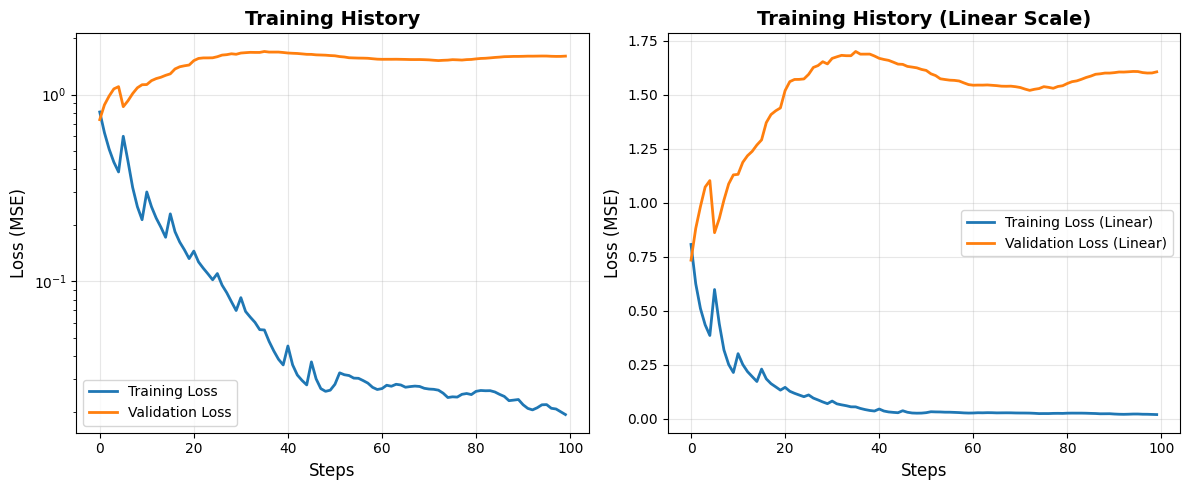

Final Training Loss: 0.019409
Final Validation Loss: 1.605750


In [14]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='Training Loss', linewidth=2)
plt.plot(results['test_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Steps', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training History', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.plot(results['train_loss'], label='Training Loss (Linear)', linewidth=2)
plt.plot(results['test_loss'], label='Validation Loss (Linear)', linewidth=2)
plt.xlabel('Steps', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training History (Linear Scale)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Loss: {results['train_loss'][-1]:.6f}")
print(f"Final Validation Loss: {results['test_loss'][-1]:.6f}")

## 5. Model Evaluation and Predictions

In [15]:
def evaluate_model(model, dataset, scaler_y, set_name="Test"):
    """
    Evaluate model performance
    
    Args:
        model: Trained KAN model
        dataset: Dictionary with 'input' and 'label' tensors
        scaler_y: Scaler for inverse transforming predictions
        set_name: Name of the dataset (for printing)
    
    Returns:
        Dictionary with predictions and metrics
    """
    # Get predictions
    model.eval()
    with torch.no_grad():
        predictions_scaled = model(dataset['input'])
    
    # Convert to numpy and inverse transform
    predictions_scaled = predictions_scaled.numpy()
    actuals_scaled = dataset['label'].numpy()
    
    predictions = scaler_y.inverse_transform(predictions_scaled)
    actuals = scaler_y.inverse_transform(actuals_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    # Direction accuracy (for trading: did we predict the right direction?)
    direction_actual = np.sign(actuals)
    direction_pred = np.sign(predictions)
    direction_accuracy = np.mean(direction_actual == direction_pred)
    
    print(f"\n{'='*50}")
    print(f"{set_name} Set Performance")
    print(f"{'='*50}")
    print(f"MSE:                 {mse:.8f}")
    print(f"RMSE:                {rmse:.8f}")
    print(f"MAE:                 {mae:.8f}")
    print(f"R² Score:            {r2:.4f}")
    print(f"Direction Accuracy:  {direction_accuracy:.2%}")
    print(f"{'='*50}")
    
    return {
        'predictions': predictions,
        'actuals': actuals,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'direction_accuracy': direction_accuracy
    }

# Evaluate on test set
test_results = evaluate_model(
    model, 
    data_dict['dataset_test'], 
    data_dict['scaler_y'],
    set_name="Test"
)


Test Set Performance
MSE:                 0.00149164
RMSE:                0.03862172
MAE:                 0.02579541
R² Score:            -5.3016
Direction Accuracy:  43.84%


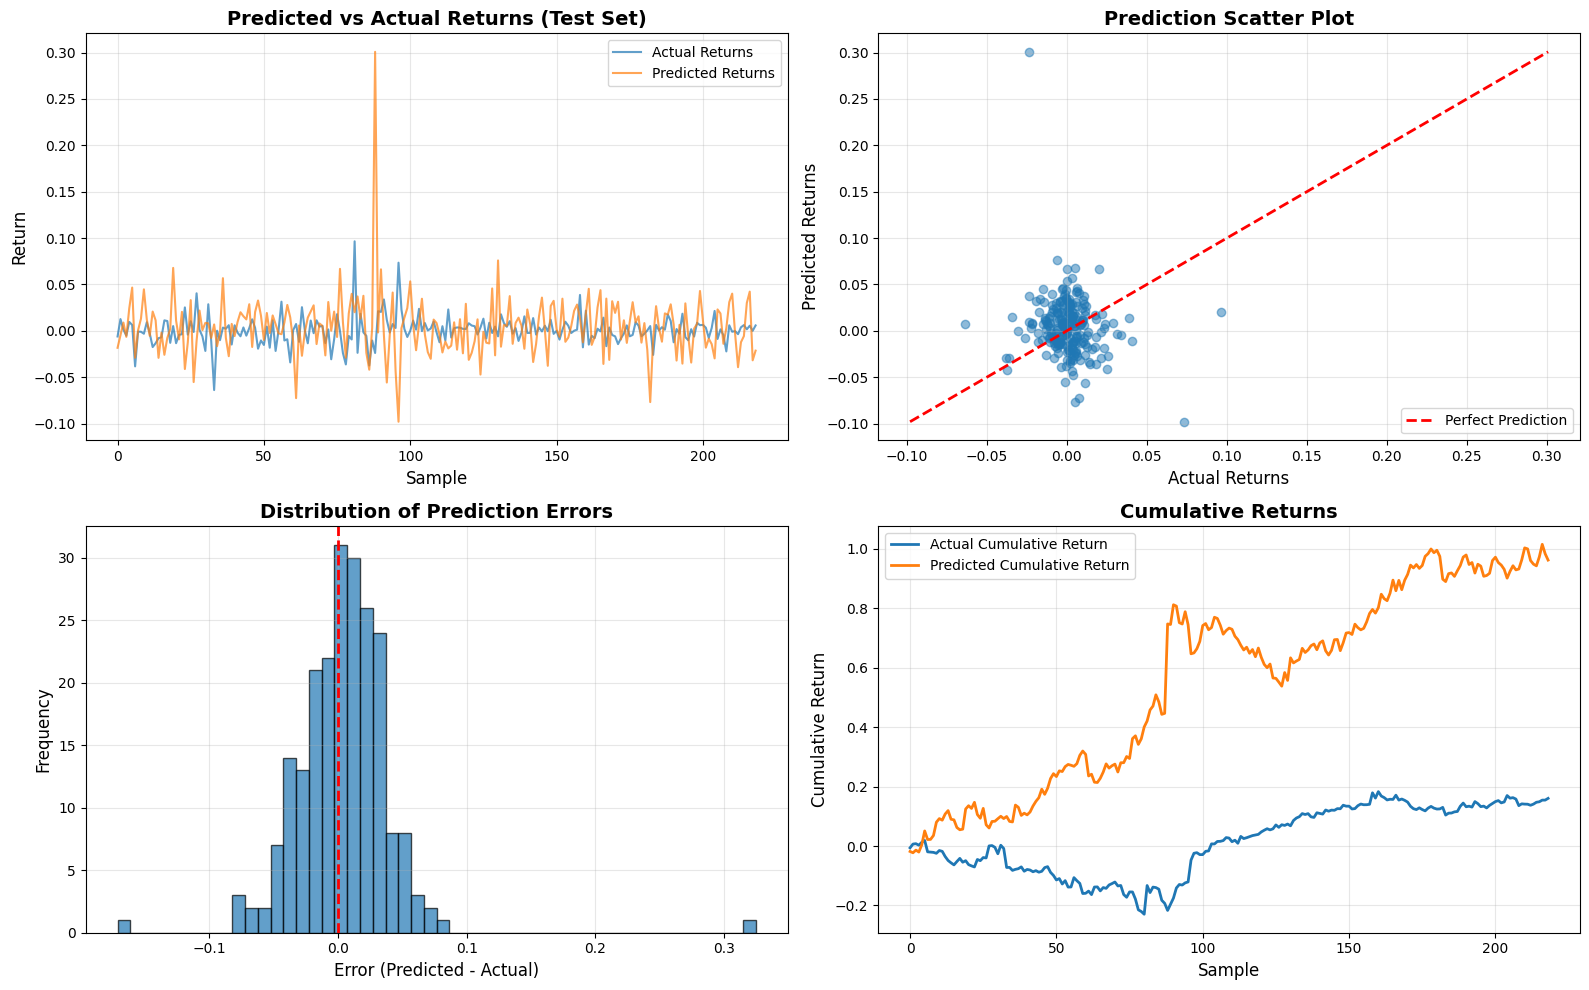

In [16]:
# Visualize predictions vs actuals
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Time series of predictions vs actuals
axes[0, 0].plot(test_results['actuals'], label='Actual Returns', alpha=0.7, linewidth=1.5)
axes[0, 0].plot(test_results['predictions'], label='Predicted Returns', alpha=0.7, linewidth=1.5)
axes[0, 0].set_title('Predicted vs Actual Returns (Test Set)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Sample', fontsize=12)
axes[0, 0].set_ylabel('Return', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Scatter plot
axes[0, 1].scatter(test_results['actuals'], test_results['predictions'], alpha=0.5)
min_val = min(test_results['actuals'].min(), test_results['predictions'].min())
max_val = max(test_results['actuals'].max(), test_results['predictions'].max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_title('Prediction Scatter Plot', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Actual Returns', fontsize=12)
axes[0, 1].set_ylabel('Predicted Returns', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Prediction errors
errors = test_results['predictions'].flatten() - test_results['actuals'].flatten()
axes[1, 0].hist(errors, bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Error (Predicted - Actual)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Cumulative returns
cumulative_actual = np.cumsum(test_results['actuals'].flatten())
cumulative_pred = np.cumsum(test_results['predictions'].flatten())
axes[1, 1].plot(cumulative_actual, label='Actual Cumulative Return', linewidth=2)
axes[1, 1].plot(cumulative_pred, label='Predicted Cumulative Return', linewidth=2)
axes[1, 1].set_title('Cumulative Returns', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Sample', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Return', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Visualize KAN Network

One of the key advantages of KAN is interpretability. Let's visualize the learned network structure.

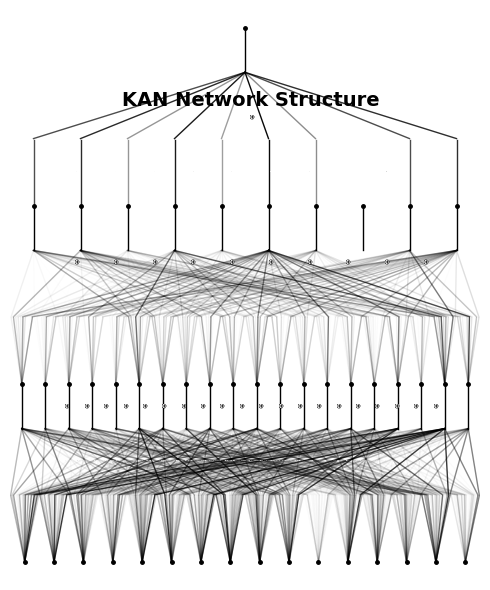


The network visualization shows the learned activation functions on each edge.
Thicker edges indicate more important connections.


In [17]:
# Plot the KAN network
try:
    model.plot(beta=3)
    plt.title('KAN Network Structure', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("\nThe network visualization shows the learned activation functions on each edge.")
    print("Thicker edges indicate more important connections.")
except Exception as e:
    print(f"Could not plot network: {e}")
    print("This is normal if the plot function requires additional dependencies.")

## 7. Feature Importance Analysis


Feature Importance (Test Set):
      Feature  Importance
 return_lag_8    0.913234
 return_lag_5    0.867183
   momentum_3    0.859154
 return_lag_7    0.853998
 return_lag_2    0.833281
 return_lag_1    0.806549
 return_lag_3    0.765841
 return_lag_9    0.759835
        ma_10    0.752373
 return_lag_6    0.741382
return_lag_10    0.736050
volatility_10    0.699521
 volatility_5    0.693300
   momentum_5    0.673689
 return_lag_4    0.658473
         ma_5    0.240627


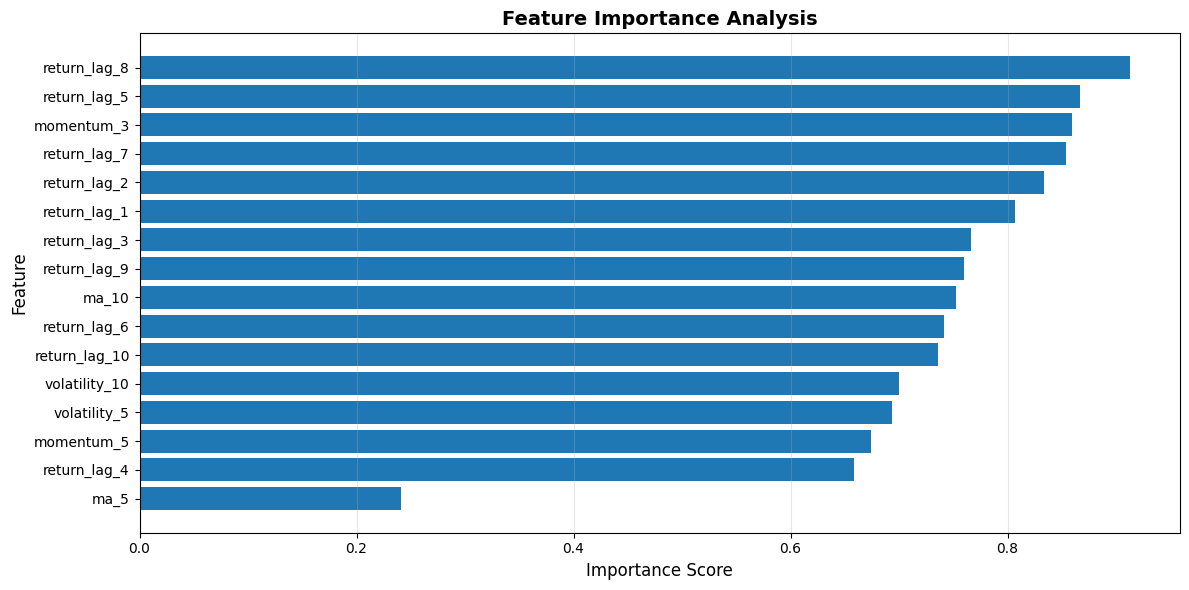

In [18]:
def analyze_feature_importance(model, dataset, feature_names):
    """
    Analyze feature importance by measuring prediction change when features are perturbed
    """
    model.eval()
    
    # Get baseline predictions
    with torch.no_grad():
        baseline_pred = model(dataset['input']).numpy()
    
    importance_scores = []
    
    # Perturb each feature
    for i in range(dataset['input'].shape[1]):
        perturbed_input = dataset['input'].clone()
        # Shuffle this feature across samples
        perturbed_input[:, i] = perturbed_input[torch.randperm(perturbed_input.shape[0]), i]
        
        with torch.no_grad():
            perturbed_pred = model(perturbed_input).numpy()
        
        # Calculate change in predictions
        importance = np.mean(np.abs(perturbed_pred - baseline_pred))
        importance_scores.append(importance)
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    }).sort_values('Importance', ascending=False)
    
    return importance_df

# Calculate feature importance
importance_df = analyze_feature_importance(
    model, 
    data_dict['dataset_test'],
    data_dict['feature_cols']
)

print("\nFeature Importance (Test Set):")
print(importance_df.to_string(index=False))

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance Analysis', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 8. Comparison with Baseline (Optional)

Let's compare KAN with a simple linear regression baseline.

In [19]:
from sklearn.linear_model import LinearRegression

# Train linear regression baseline
lr_model = LinearRegression()
X_train = data_dict['dataset_train']['train_input'].numpy()
y_train = data_dict['dataset_train']['train_label'].numpy()
lr_model.fit(X_train, y_train)

# Predictions
X_test = data_dict['dataset_test']['input'].numpy()
y_test = data_dict['dataset_test']['label'].numpy()
lr_pred_scaled = lr_model.predict(X_test)

# Inverse transform
lr_pred = data_dict['scaler_y'].inverse_transform(lr_pred_scaled)
y_test_actual = data_dict['scaler_y'].inverse_transform(y_test)

# Calculate metrics
lr_mse = mean_squared_error(y_test_actual, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test_actual, lr_pred)
lr_r2 = r2_score(y_test_actual, lr_pred)
lr_direction_accuracy = np.mean(np.sign(y_test_actual) == np.sign(lr_pred))

# Comparison table
comparison = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²', 'Direction Accuracy'],
    'KAN': [
        test_results['mse'],
        test_results['rmse'],
        test_results['mae'],
        test_results['r2'],
        test_results['direction_accuracy']
    ],
    'Linear Regression': [
        lr_mse,
        lr_rmse,
        lr_mae,
        lr_r2,
        lr_direction_accuracy
    ]
})

comparison['Improvement'] = ((comparison['Linear Regression'] - comparison['KAN']) / 
                             comparison['Linear Regression'] * 100)
comparison.loc[comparison['Metric'] == 'R²', 'Improvement'] = (
    (comparison.loc[comparison['Metric'] == 'R²', 'KAN'].values[0] - 
     comparison.loc[comparison['Metric'] == 'R²', 'Linear Regression'].values[0]) / 
    abs(comparison.loc[comparison['Metric'] == 'R²', 'Linear Regression'].values[0]) * 100
)
comparison.loc[comparison['Metric'] == 'Direction Accuracy', 'Improvement'] = (
    (comparison.loc[comparison['Metric'] == 'Direction Accuracy', 'KAN'].values[0] - 
     comparison.loc[comparison['Metric'] == 'Direction Accuracy', 'Linear Regression'].values[0]) / 
    comparison.loc[comparison['Metric'] == 'Direction Accuracy', 'Linear Regression'].values[0] * 100
)

print("\n" + "="*70)
print("KAN vs Linear Regression Comparison")
print("="*70)
print(comparison.to_string(index=False))
print("\nNote: Positive improvement means KAN performs better")
print("="*70)


KAN vs Linear Regression Comparison
            Metric       KAN  Linear Regression   Improvement
               MSE  0.001492           0.000245   -509.791717
              RMSE  0.038622           0.015640   -146.939612
               MAE  0.025795           0.010252   -151.602286
                R² -5.301638          -0.033408 -15769.287203
Direction Accuracy  0.438356           0.511416    -14.285714

Note: Positive improvement means KAN performs better


## 9. Summary and Next Steps

### Key Takeaways

1. **KAN for Stock Prediction**: We successfully applied KAN to autoregressive stock forecasting
2. **Advantages**:
   - Learnable activation functions adapt to data patterns
   - Better interpretability through network visualization
   - Can capture complex non-linear relationships
3. **Challenges**:
   - Training is slower than MLPs
   - Requires careful hyperparameter tuning
   - More parameters to configure (grid size, spline order, etc.)

### Potential Improvements

1. **Architecture tuning**:
   - Experiment with different layer sizes
   - Try different grid sizes and spline orders
   - Add/remove hidden layers

2. **Feature engineering**:
   - Add more technical indicators (RSI, MACD, Bollinger Bands)
   - Include market sentiment data
   - Add macro-economic features

3. **Training optimization**:
   - Try different optimizers (Adam, SGD)
   - Implement learning rate scheduling
   - Use early stopping

4. **Multi-step forecasting**:
   - Predict multiple days ahead
   - Implement recursive forecasting

5. **Portfolio optimization**:
   - Extend to multiple stocks
   - Implement trading strategy based on predictions
   - Backtest with realistic transaction costs

In [20]:
# Save the trained model
import pickle

model_save_path = 'kan_stock_ar_model.pkl'

with open(model_save_path, 'wb') as f:
    pickle.dump({
        'model_state': model.state_dict(),
        'model_config': {
            'width': WIDTH,
            'grid': GRID,
            'k': K
        },
        'scaler_X': data_dict['scaler_X'],
        'scaler_y': data_dict['scaler_y'],
        'feature_cols': data_dict['feature_cols'],
        'lookback_window': LOOKBACK_WINDOW
    }, f)

print(f"Model saved to: {model_save_path}")
print("\nTo load the model later, use:")
print("""with open('kan_stock_ar_model.pkl', 'rb') as f:
    checkpoint = pickle.load(f)
    model = KAN(width=checkpoint['model_config']['width'], 
                grid=checkpoint['model_config']['grid'],
                k=checkpoint['model_config']['k'])
    model.load_state_dict(checkpoint['model_state'])""")

Model saved to: kan_stock_ar_model.pkl

To load the model later, use:
with open('kan_stock_ar_model.pkl', 'rb') as f:
    checkpoint = pickle.load(f)
    model = KAN(width=checkpoint['model_config']['width'], 
                grid=checkpoint['model_config']['grid'],
                k=checkpoint['model_config']['k'])
    model.load_state_dict(checkpoint['model_state'])
